# Week 4 - Partial Least Squares Regression

We will reimplement and then explore some of the properties of [Cosgrove et al](http://pubs.rsc.org/en/Content/ArticleLanding/2010/MB/b926287c).

In [2]:
import scipy
import scipy.io
import numpy as np
from sklearn.metrics import r2_score
from sklearn.preprocessing import scale, StandardScaler
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import LeaveOneGroupOut, LeaveOneOut
import matplotlib.pyplot as plt
data = scipy.io.loadmat('wk4_Cosgrove-data.mat', squeeze_me=True)['s']
X = data['X'].item() # the untransformed data matrix (66x102)
Y = data['Y'].item() # the untransformed LDH release at 48hours. (66x1) (66 by (5 or take this array as one))
phosphoproteins = data['phosphoproteins'].item() # names of phosphoproteins(102x1)
conditions = data['conditions'].item() # cell array of the 66 conditions (66x1)
drugList = data['drugList'].item() # description of the drugs used in each of the 66 conditions (66x1)
drugListToxic = data['drugListToxic'].item() # binary value corresponding to whether drugList[i] is toxic (11x1)
drugs = data['drugs'].item() # binary matrix mapping which measurements correspond to a drug treatment in drugList (66x11)
cytokineList = data['cytokineList'].item() # cell array of cytokine treatments (6x1)
cytokines = data['cytokines'].item()
ind4pProtein = data['ind4pProtein'].item() # the column indices corresponding to measurements of the 4 phosphoprotein subset(24x1)

#### (1) Perform PLSR on the matrixes X and Y. Plot the percent variance explained. How many principal components do you need for each to explain 90% of the Y variance? Discuss your findings.

Hint: Be sure you are normalizing each dataset as needed for the analysis.

[[-1.03085789 -0.54056419  2.28681342 ... -0.85994692 -0.78142716
  -0.96980722]
 [-0.30283958 -0.35474525  1.29385496 ...  0.47550006  0.95967241
   1.00896663]
 [-0.96467441 -0.16892631  0.79737573 ... -0.08093618 -0.21674622
  -0.4448264 ]
 ...
 [-0.36902306  0.20271157 -1.4367808  ... -1.08252141 -1.01671089
  -0.6467421 ]
 [ 1.88121537  0.57434945 -1.68502041 ... -1.30509591 -1.34610811
  -1.33325548]
 [ 1.94739886  2.06090098 -0.44382234 ... -1.08252141 -0.96965414
  -0.4448264 ]]
[-0.66423467 -0.69891781 -0.62955153 -0.66423467 -0.59486839 -0.49081897
 -0.73360094 -0.80296722 -0.76828408 -0.80296722 -0.73360094 -0.69891781
 -0.66423467 -0.59486839 -0.62955153 -0.66423467 -0.49081897 -0.49081897
 -0.76828408 -0.69891781 -0.62955153 -0.73360094 -0.66423467 -0.52550211
 -0.66423467 -0.69891781 -0.59486839 -0.49081897 -0.69891781  0.51499207
 -0.66423467 -0.73360094 -0.66423467 -0.66423467 -0.69891781 -0.45613583
  0.58435835  1.90231764  1.93700078  1.97168391  0.86182346  2.491931

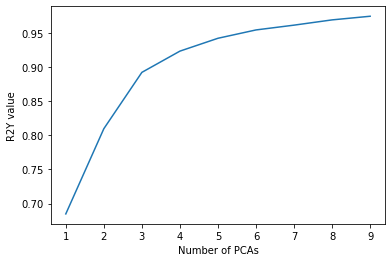

In [4]:
# Answer
X_S = scale(X)
print(X_S)
Y4 = Y[:,4]
Y_S = scale(Y4)
print(Y_S)
R2Y = []
#print(Y_S)
for n in range (1, 10):
    pls = PLSRegression(n_components = n, scale=True, max_iter=500, tol=1e-06, copy=True)
    pls.fit_transform(X_S, Y_S)
    r2 = pls.score(X_S, Y_S)
    R2Y = np.append(R2Y, r2)

pcas = np.arange(1,10,1)    
plt.plot(pcas,R2Y)
plt.xlabel("Number of PCAs")
plt.ylabel("R2Y value")
min90 = np.min(np.where(R2Y>=0.9))
min90 = min90 +1

print("Number of PCs required to reach 90% explanation of Y variance: " , min90)
print("Array of Percentage of variance in prediction explained by the sum of total PCAs: " , R2Y)

These findings show that a majority of the variance of the prediction is explained in the first four PCs. This would show that most of the model can be explained by four principle components which are linear transforms of 102 available varialbes we have in the X data. 

#### (2) How would you expect the percent of X variance explained to compare between PLSR and PCA? Why?

Answer.
The percent of X variance for each principal compnent would be higher in PCA than PLSR. For example, PC 1 in PCA may explain 60% of the variance of X in PCA, but only 45% of the variance in PLSR. Therefore, less variance would be predicted by PLSR to PCA, and that is true for the sum, of the variance explaned by the PCA and PLSR. Such that the sum of variance explained by PCA would always be greater than the sum of the variance exlained by PLSR, and PCA would convene to 1 with fewer PCs.  

#### (3) Recreate the Figure S2A plot from Cosgrove et al. supplementary information. This is the PLSR scores plot (for PC1 and PC2), with toxic drugs colored according to the drug type and all other drugs are not colored. Use the drugList, drugListToxic to identify these categories.

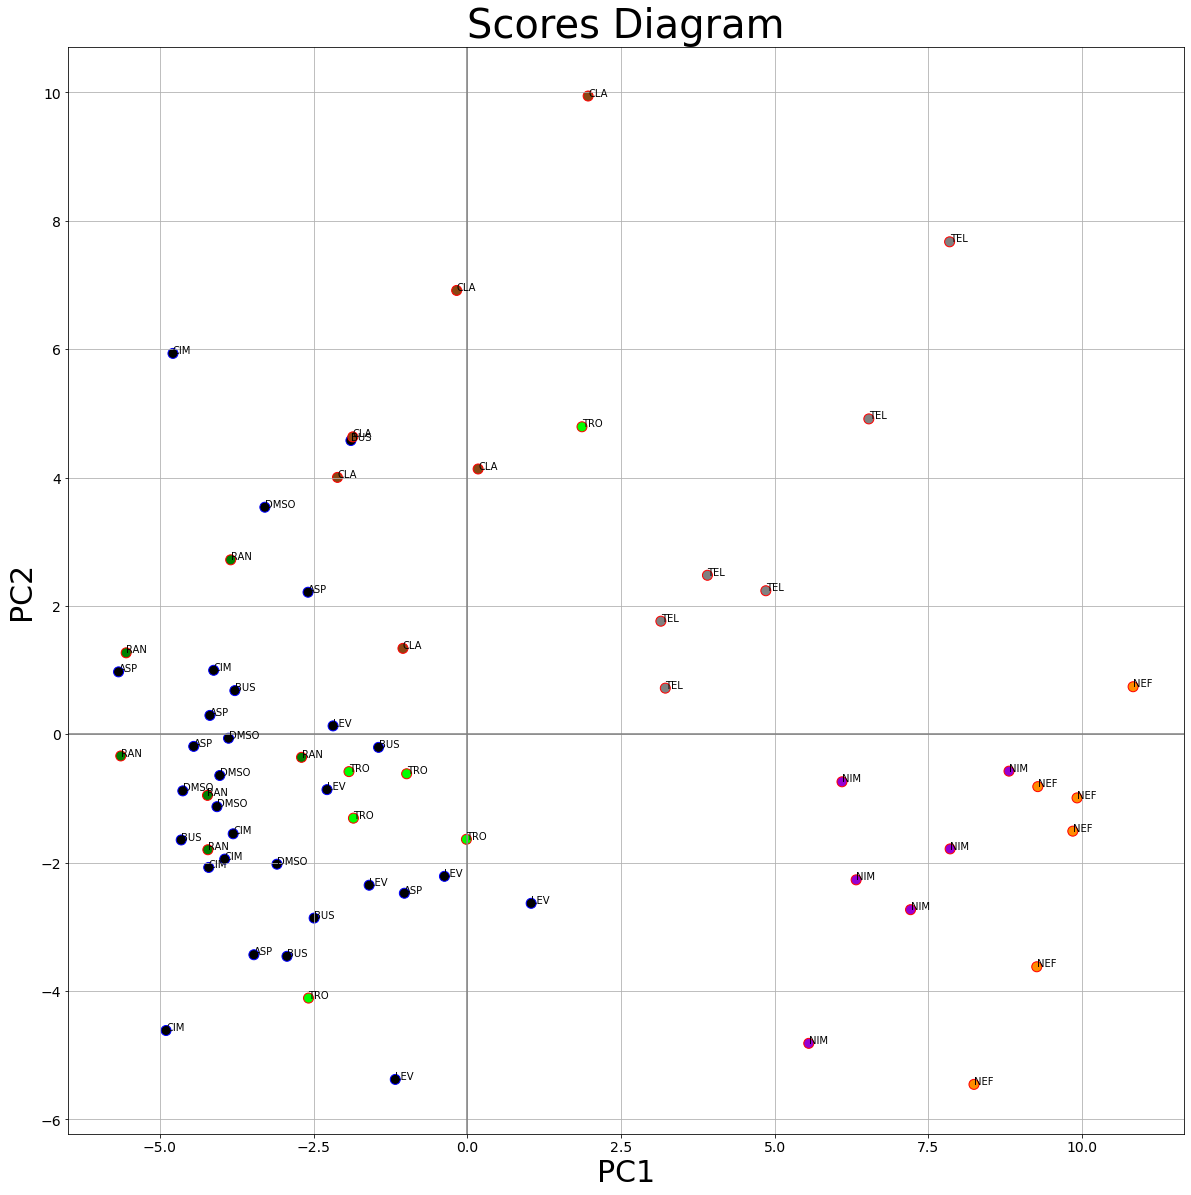

In [4]:
# Answer
#plot scores plots for X and Y (for PC1 and PC2) 
X_S = (X)
Y4 = Y[:,4]
Y_S = (Y4)
pls2 = PLSRegression(n_components = 2, scale=True, max_iter=500, tol=1e-06, copy=True)
pls2.fit_transform(X_S, Y_S)

xscores = pls2.x_scores_
yscores = pls2.y_scores_
pc1x = (xscores[:,0])
pc2x = xscores[:,1]
pc1y = (yscores[:,0])
pc2y = yscores[:,1]
#print((xscores))
drug_groups = np.zeros([66])
drug_groups_names = []
drug_groups_toxic = []
drug_colors = ['black', 'black', 'g', 'black' ,'lime' ,'black', 'darkorange' ,'black', 'darkviolet' ,'saddlebrown' ,'gray']
drug_color_map = []#np.empty([] , dtype = np.str_)
edge_shape_map = np.empty([66] , dtype = np.str_)

for m in range (0, np.size(pc1x)):
    c = (m //6)
    drug_groups[m] =  c+1
    drug_groups_names.append(drugList[c])
    drug_groups_toxic.append(drugListToxic[c])
    drug_color_map.append(drug_colors[c])
    

for k in range (0, np.size(drug_groups_toxic)):
    if drug_groups_toxic[k] == 1:
        edge_shape_map[k] = 'r'
    else:
         edge_shape_map[k] = 'b'
            
edge_list = edge_shape_map.tolist()

plt.figure(figsize = (20,20))
sobs = plt.scatter(pc1x, pc2x, s= 100 ,edgecolors = edge_list, c = drug_color_map)
#spred = plt.scatter(pc1y, pc2y, s = 100, marker = 'd' ,edgecolors = edge_list, c = drug_color_map )
for iii, label in enumerate(drug_groups_names):
    plt.annotate(label, (pc1x[iii], pc2x[iii]))

plt.tick_params(axis = 'x', labelsize = 14)
plt.tick_params(axis = 'y', labelsize = 14)
plt.xlabel('PC1', size = 30)
plt.ylabel('PC2', size = 30)
plt.axhline(0, color='gray')
plt.axvline(0, color='gray')
plt.title('Scores Diagram', size = 40)

plt.grid(True)



Colors define the drugs used:
'DMSO' - black
'CIM' - black
'RAN' - green
'LEV' - black
'TRO' - lime
'BUS' - black
'NEF' - orange
'ASP' - black
'NIM' - violet
'CLA' - brown
'TEL' - gray

Points with red edges are toxic drugs
Points with blue edges are non-toxic drugs


#### (4) Create the loadings plot corresponding to (2). Interpret the results shown on the plot.

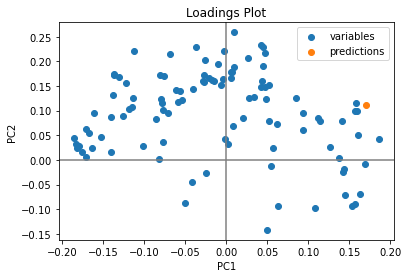

In [5]:
# Answer
X_S = scale(X)
Y4 = Y[:,4]
Y_S = scale(Y4)
pls2 = PLSRegression(n_components = 2, scale=True, max_iter=500, tol=1e-06, copy=True)
pls2.fit_transform(X_S, Y_S)

xloadings = pls2.x_loadings_
yloadings = pls2.y_loadings_
pc1xl = (xloadings[:,0])
pc2xl = xloadings[:,1]
pc1yl = (yloadings[:,0])
pc2yl = yloadings[:,1]
#print((xscores))


plt.figure()
var = plt.scatter(pc1xl, pc2xl)
pred = plt.scatter(pc1yl, pc2yl)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Loadings Plot")
plt.axhline(0, color='gray')
plt.axvline(0, color='gray')
plt.legend([var, pred], ['variables', 'predictions']);


The loadings plot is broken into four quadrants, based on the axes of PC1 and PC2. (normal mathematical quadrant labeling applies) 
For the X loadings, quadrant 1 shows the varible predictors that are positively correlated to both PC1 and PC2, the second quadrant shows the variables that are negatively correlated to PC1 and positevely correlated to PC2. The third quadrant shows the variables that are negatively correaltated to PC2 and PC1, and the fourth quadrant shows the variables that are positively correlated to PC1 and negatively correlated to PC2. Any point on the PC1 axis means PC2 does not affect it at all, and any point on the PC2 axis means that PC1 does not have any affect at all. The greater the Euclidean distance from the origin point represent the magnitude of the affect the PCs are correlated to that variable given its position in the quadrants. 
For the Y-loadings this plot shows how the PCs affect the variable outcomes. There is one given in the model, and it is corelated to the PCs (with quadrant correlation and magnitude correlation) in the same way that the varible predictors are corelated.  It can also be shown that the variable predictors that are nearer to the variable predictions in respect to euclidean are more associated to those variable predictions. 
Points of note: The prediction variables that are close to the origin of the plot mean that the PCs do not really explain or effect these points. 

#### (5) Add the variance of the loadings to your loadings plot (this can be shown as error bars). How does the variance of component one compare to that of component two? Would you expect a trend in the general variance versus component number?

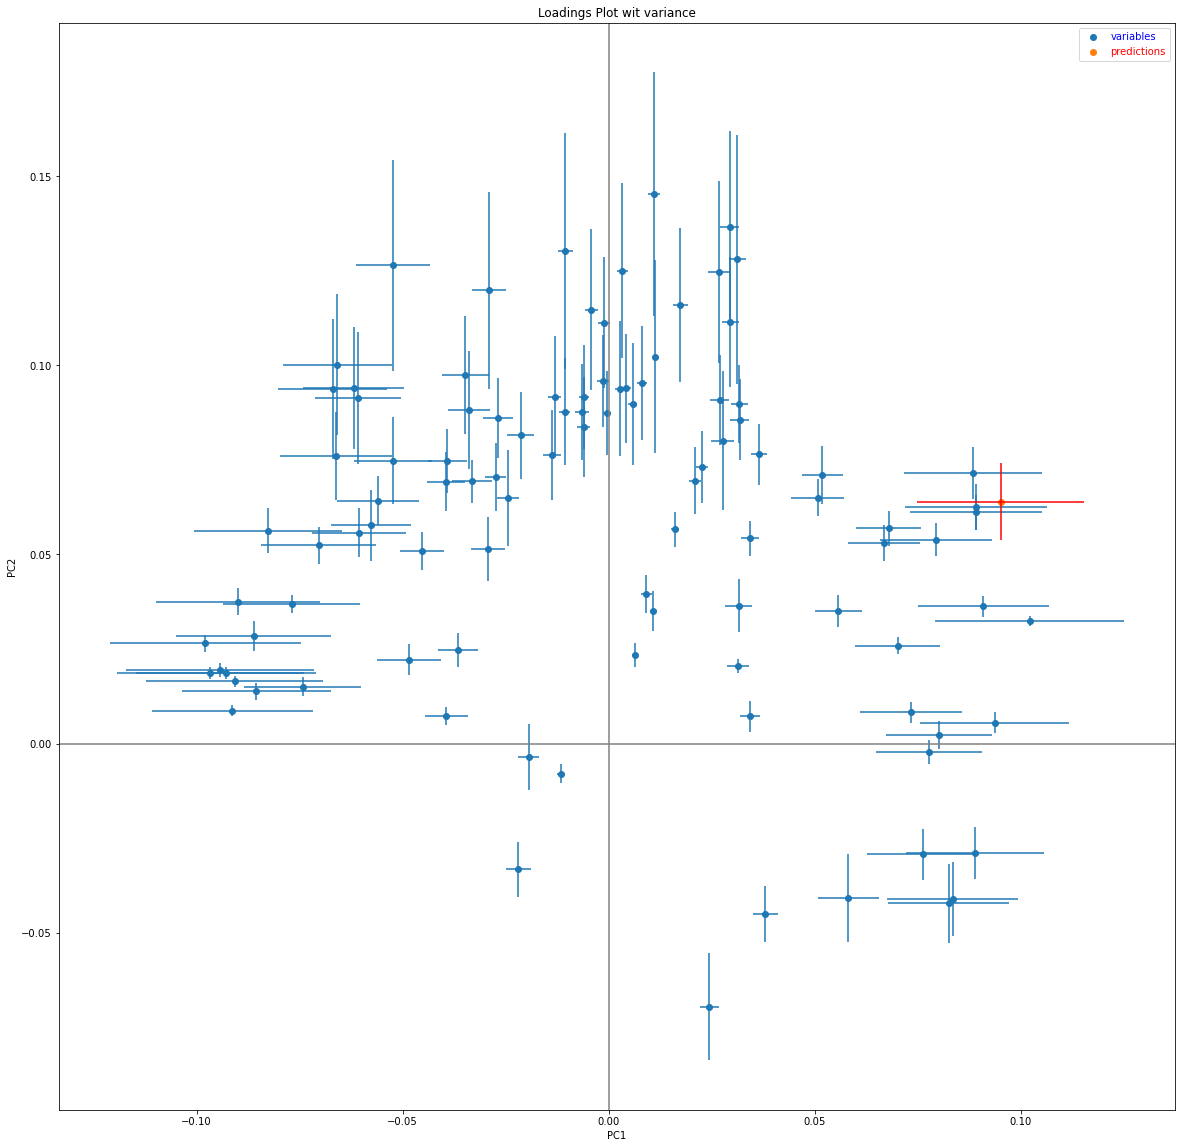

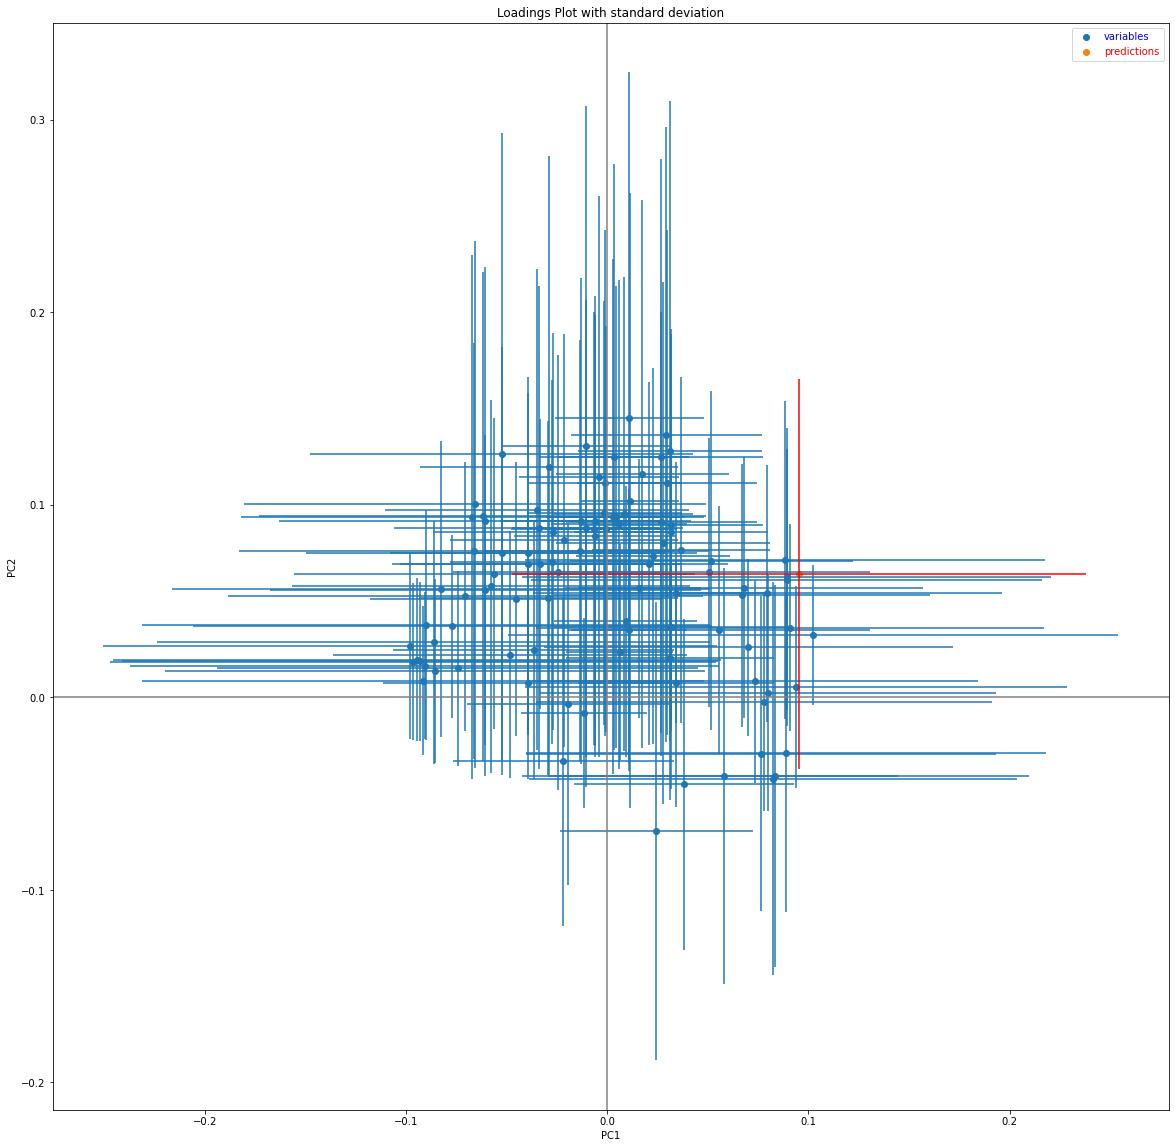

In [6]:
# Answer.
from sklearn.utils import resample
pls2 = PLSRegression(n_components = 2, scale=True, max_iter=500, tol=1e-06, copy=True)

arr_pc1_xrl = np.zeros([102,1001])
arr_pc2_xrl = np.zeros([102,1001])
arr_pc1_yrl = np.zeros([1,1001])
arr_pc2_yrl = np.zeros([1,1001])

variance_pc1_xrl = np.zeros(102)
variance_pc2_xrl = np.zeros(102)
mean_pc1_xrl = np.zeros(102)
mean_pc2_xrl = np.zeros(102)
std_pc1_xrl = np.zeros(102)
std_pc2_xrl = np.zeros(102)


variance_pc1_yrl = np.zeros(1)
variance_pc2_yrl = np.zeros(1)
mean_pc1_yrl = np.zeros(1)
mean_pc2_yrl = np.zeros(1)
std_pc1_yrl = np.zeros(1)
std_pc2_yrl = np.zeros(1)


pcx0 = np.zeros(1001)
pcx02 = np.zeros([1,1001])
sumx0 = 0

ii=0
for ii in range (0,1001):
    X = data['X'].item()
    Y = data['Y'].item()
    Y4 = Y[:,4]
    resamp = resample(range(X.shape[0]))
    XR_S = X[resamp]; YR_S = Y4[resamp]
    pls2.fit_transform(XR_S, YR_S)
    xrloadings = pls2.x_loadings_
    yrloadings = pls2.y_loadings_
    pc1xlr = (xrloadings[:,0])
    pc2xlr = xrloadings[:,1]
    pc1ylr = (yrloadings[:,0])
    pc2ylr = yrloadings[:,1]
    nn=0
    mm=0
    for nn in range (0, np.size(pc1xlr)):
        arr_pc1_xrl[nn,ii] = pc1xlr[nn]
        arr_pc2_xrl[nn,ii] = pc2xlr[nn]

    for mm in range (0, np.size(pc1ylr)):
        arr_pc1_yrl[mm,ii] = pc1ylr
        arr_pc2_yrl[mm,ii] = pc2ylr   

rr=0       
for rr in range(0,102):
    variance_pc1_xrl[rr] = np.var(arr_pc1_xrl[rr,:])
    variance_pc2_xrl[rr] = np.var(arr_pc2_xrl[rr,:])
    std_pc1_xrl[rr] = np.std(arr_pc1_xrl[rr,:])
    std_pc2_xrl[rr] = np.std(arr_pc2_xrl[rr,:])
    mean_pc1_xrl[rr] = np.mean(arr_pc1_xrl[rr,:])
    mean_pc2_xrl[rr] = np.mean(arr_pc2_xrl[rr,:])
    
kk=0
for kk in range(0,1):
    variance_pc1_yrl[kk] = np.var(arr_pc1_yrl[kk,:])
    variance_pc2_yrl[kk] = np.var(arr_pc2_yrl[kk,:])
    std_pc1_yrl[kk] = np.std(arr_pc1_yrl[kk,:])
    std_pc2_yrl[kk] = np.std(arr_pc2_yrl[kk,:])
    mean_pc1_yrl[kk] = np.mean(arr_pc1_yrl[kk,:])
    mean_pc2_yrl[kk] = np.mean(arr_pc2_yrl[kk,:])   



    
plt.figure(figsize = (20,20))
meanplotx = plt.scatter(mean_pc1_xrl, mean_pc2_xrl)
varx = plt.errorbar(mean_pc1_xrl, mean_pc2_xrl, xerr = variance_pc1_xrl, yerr = variance_pc2_xrl, fmt ='none')
vary = plt.errorbar(mean_pc1_yrl, mean_pc2_yrl, xerr = variance_pc1_yrl, yerr = variance_pc2_yrl, fmt ='none', ecolor = 'r')
meanploty = plt.scatter(mean_pc1_yrl, mean_pc2_yrl)
#pred = plt.scatter(pc1yl, pc2yl)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Loadings Plot wit variance")
plt.axhline(0, color='gray')
plt.axvline(0, color='gray')
plt.legend([var, pred], ['variables', 'predictions'], labelcolor = ['b', 'r']);

plt.figure(figsize = (20,20))
meanplotx = plt.scatter(mean_pc1_xrl, mean_pc2_xrl)
stdx = plt.errorbar(mean_pc1_xrl, mean_pc2_xrl, xerr = std_pc1_xrl, yerr = std_pc2_xrl, fmt ='none')
stdy = plt.errorbar(mean_pc1_yrl, mean_pc2_yrl, xerr = std_pc1_yrl, yerr = std_pc2_yrl, fmt ='none', ecolor = 'r')
meanploty = plt.scatter(mean_pc1_yrl, mean_pc2_yrl)
#pred = plt.scatter(pc1yl, pc2yl)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Loadings Plot with standard deviation")
plt.axhline(0, color='gray')
plt.axvline(0, color='gray')
plt.legend([var, pred], ['variables', 'predictions'], labelcolor = ['b', 'r']);
    



 

How does the variance of component one compare to that of component two? 
    Component one's variance decreases as it gets closer to Component two axis (y-axis) (PC1 = 0), and Component two's variance decreases as it aproaches the PC1 axis (x-axis) (PC2 = 0). 

Would you expect a trend in the general variance versus component number?
As the components get closer to where they are zero, the variance in those components decrease. As they get further away from the 0 points, the variance increases. 
The general trend of variance in a component increasing as it gets farther from 0 makes sense, because the closer we are to the origin the smaller the values would be when squared no matter what, and thus the variance would be smaller. Therefore, I would expect variance to always increase the further from the PC's origin. This also makes sense when thinking about how the variables are related to the PCs, if the variables are close to the origin, they won't have as much affect on the PC system, so the variance of it to the system is small, where as larger values will add more of an affect to the system. 

#### (6) Recreate a 4-principal component model using PLSR with just the final 4 phosphoprotein model. Plot predicted v. observed LDH for this model. Report the model fitness ($R^2$). Define here how you are calculating $R^2$.

R2 value calculated by using the formula given in the Cosgrove paper (equation in code): 0.8664571983627838
R2 value calculated by using the score function given in the partial least squares regression code from sklearn, uses 1 - (sum(Y4-self.predict(XX))^2 / sum((Y4 - mean(Y4))^2) :  0.8821898904528919
R2 value calculated by using the score function given in the partial least squares regression code from sklearn, uses 1 - (sum((Y4-ypredicted)^2) / sum((Y4 - mean(Y4))^2) :  0.8821898904528919


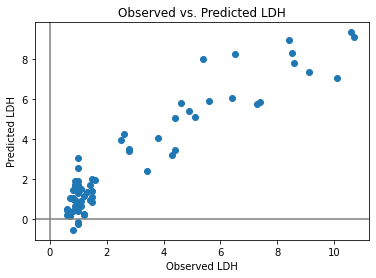

In [7]:
# Answer
XX = X[:, ind4pProtein]
Y4 = Y[:,4]

pls4 = PLSRegression(n_components = 4, scale=True, max_iter=500, tol=1e-06, copy=True)
pls4.fit_transform(XX, Y4)
ypredicted = pls4.predict(XX)

ypredT = ypredicted.T
ypredTf = ypredT.reshape(66)

numer = ((((ypredTf - Y4)**2).sum()))
denom = (  (((ypredTf)**2).sum()) - (((ypredTf).sum())**2)/(np.size(Y[:,0])))
fitmody = 1 - (numer/denom)

print("R2 value calculated by using the formula given in the Cosgrove paper (equation in code):" , fitmody)

print("R2 value calculated by using the score function given in the partial least squares regression code from sklearn, uses 1 - (sum(Y4-self.predict(XX))^2 / sum((Y4 - mean(Y4))^2) : ", pls4.score(XX,Y4))


yr2 = r2_score(Y4, ypredicted)
print("R2 value calculated by using the score function given in the partial least squares regression code from sklearn, uses 1 - (sum((Y4-ypredicted)^2) / sum((Y4 - mean(Y4))^2) : " , yr2)



plt.figure()
# = plt.scatter(pc1xl, pc2xl)
ysc = plt.scatter(Y4, ypredicted)
#ytr = plt.scatter(
plt.xlabel("Observed LDH")
plt.ylabel("Predicted LDH")
plt.title("Observed vs. Predicted LDH")
plt.axhline(0, color='gray')
plt.axvline(0, color='gray');
#plt.legend([var, pred], ['variables', 'predictions']);



#### (7) Cosgrove *et al* discusses their method for model validation using leave-one-out cross-validation. Calculate all LDH predictions for leave-one-out cross-validation and calculate the R^2 value for the resulting yfit values. What is the R^2 value? Why do you think it’s important to perform cross-validation?

[[ 0.9         1.7         1.1        ...  1.2         5.1
   0.8       ]
 [ 0.9         1.5         1.2        ...  1.66666667 36.7
   0.9       ]
 [ 0.9         1.3         1.3        ...  1.63333333 10.3
   0.8       ]
 ...
 [ 1.5         1.3         1.3        ...  9.26666667 57.1
   1.        ]
 [ 1.3         1.          0.9        ...  8.93333333 34.4
   1.        ]
 [ 1.5         1.2         1.         ... 12.56666667 69.6
   1.2       ]]
[ 1.   0.9  1.1  1.   1.2  1.5  0.8  0.6  0.7  0.6  0.8  0.9  1.   1.2
  1.1  1.   1.5  1.5  0.7  0.9  1.1  0.8  1.   1.4  1.   0.9  1.2  1.5
  0.9  4.4  1.   0.8  1.   1.   0.9  1.6  4.6  8.4  8.5  8.6  5.4 10.1
  1.3  0.6  1.   1.   0.8  1.4  2.5  2.8  5.1  4.4  2.6  7.4  3.4  2.8
  4.3  5.6  3.8  4.9  7.3  6.4  9.1  6.5 10.7 10.6]
R2 score for the orginal data:  0.8807720007604107

R2Y correlation coefficient acording to class equation:  0.6894972555303185

R2Y Pearson correlation coefficient acording to paper equation:  0.7768450852326593



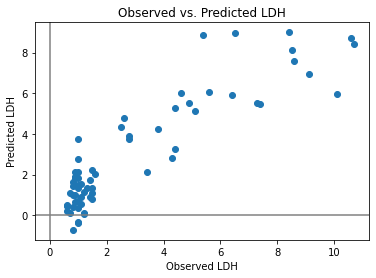

In [9]:
# Answer
from sklearn.model_selection import LeaveOneOut
leaveOO = LeaveOneOut()

XX = X[:, ind4pProtein]
print(XX)
Y4 = Y[:,4]
print(Y4)
leave_one_out_ind = np.arange(len(XX[:,0]))
predict_test_vals = np.zeros(len(XX[:,0]))

for train_index, test_index in leaveOO.split(leave_one_out_ind):
    trainXX = XX[train_index]
    trainY4 = Y4[train_index]
    pls4co = PLSRegression(n_components = 4, scale=True, max_iter=500, tol=1e-06, copy=True)
    pls4co.fit_transform(trainXX, trainY4)
    #print(pls4co.score(XX,Y4))
    predict_test_vals[test_index] = pls4co.predict(XX[test_index])

print("R2 score for the orginal data: ", pls4co.score(XX,Y4))
print()

#yr2cv = r2_score(Y4, predict_test_vals)
#print(yr2cv)
#print()

numer2 = ((((Y4 - predict_test_vals)**2).sum())**0.5)
denom2 = (((Y4)**2).sum())**0.5
fitmody2 = 1 - (numer2/denom2)       
print("R2Y correlation coefficient acording to class equation: ", fitmody2)
print()

numer = ((((predict_test_vals - Y4)**2).sum()))
denom = (  (((predict_test_vals)**2).sum()) - (((predict_test_vals).sum())**2)/(np.size(predict_test_vals)))
fitmody = 1 - (numer/denom)
print("R2Y Pearson correlation coefficient acording to paper equation: ",fitmody)
print()

numer2 = ((((Y4 - predict_test_vals)**2).sum()))
denom2 = (((Y4-np.mean(Y4))**2).sum())
fitmody3 = 1 - (numer2/denom2)       
print("R2Y correlation coefficient acording to sklearn equation: " , fitmody3)
print()



#cvloscore = pls4co.score(XX, predict_test_vals)
#print(cvloscore)
#print()


plt.figure()

ysc = plt.scatter(Y4, predict_test_vals)
plt.xlabel("Observed LDH")
plt.ylabel("Predicted LDH")
plt.title("Observed vs. Predicted LDH")
plt.axhline(0, color='gray')
plt.axvline(0, color='gray');   



What is the R^2 value? The R^2 value in this case is how well the original data fits with the predicted outputs, giving us an estimation of how good our predictive model is. The R2 value I would use is the coeficient given in the paper, as that gives us the comparison to our model and the model given in the paper as well. 

It is important to run cross validation, because as we can see our R2 value decreases, no matter which equation you use. This is because we are basing our model with one less point, thereby limiting the predictive power of the model. However, because we are able to use the point we take out as a comparison to the the prediction for that point, we can get a measure of how good our model predicts. Higher the correlation, the higher the predictive power. Also this is guarenteed to be our absolute minimum in predictive power, since the actual model is a better model than the models we used to make our predictions. 


Why do you think it’s important to perform cross-validation?
It isimporant to perform cross-validation, because it gives us a way to estimate how well our model is at predicting new data without gathering more data. It gives us a way to get the maximum prediction error of our orginal model since we are always predicting with a model that has one less data point than our original model. It overestimates our prediction error.

#### (8) Now, instead of performing LOOCV, let's perform leave-one-cytokine-out cross-validation. That is, one cytokine at a time, leave out all the data for the `NoCyt`, `IL-1`, `LPS`, `TNF`, `IL-6`, or `Mix` conditions.

Hint: Look at `sklearn.model_selection.LeaveOneGroupOut`.

How does this affect your cross-validation? How do the two approaches here differ? When might each be most appropriate?

In [29]:
data = scipy.io.loadmat('wk4_Cosgrove-data.mat', squeeze_me=True)['s']
cytokines = data['cytokines'].item()
cytogroups = np.zeros_like(cytokines)
groups = np.zeros_like(cytokines[:,0])
for rr in range(np.size(cytokines[:,0])):
    cc = 0
    while cc < np.size(cytokines[0,:]):
            if cytokines[rr,cc] == 1:
                groups[rr] = (cc+1)
                #cytogroups[rr,cc] = cc+1
                cc = cc+1
            else:
                cc = cc + 1         


Number of Groups:  6
R2 score for the original data:  0.8474784515771074

R2Y correlation coefficient acording to class equation:  0.6894972555303185

R2Y Pearson correlation coefficient acording to paper equation:  0.7768450852326593

R2Y correlation coefficient acording to sklearn equation:  0.8050304842834812



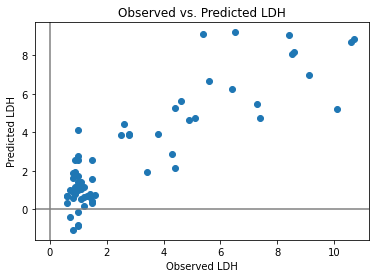

In [46]:
# Answer
data = scipy.io.loadmat('wk4_Cosgrove-data.mat', squeeze_me=True)['s']
cytokineList = data['cytokineList'].item() # cell array of cytokine treatments (6x1)
cytokines = data['cytokines'].item()

from sklearn.model_selection import LeaveOneGroupOut
leaveOG = LeaveOneGroupOut()

leave_group_ind = np.arange(len(cytokines))

XX = X[:, ind4pProtein]
Y4 = Y[:,4]

print("Number of Groups: " ,leaveOG.get_n_splits(XX, Y4, groups))

predict_test_vals_cg = np.zeros([66,1])

for train_index, test_index in leaveOG.split(XX, Y4, groups):
    #print(train_index)
    trainXX = XX[train_index]
    trainY4 = Y4[train_index]
    pls4cg = PLSRegression(n_components = 4, scale=True, max_iter=500, tol=1e-06, copy=True)
    pls4cg.fit_transform(trainXX, trainY4)
    predict_test_vals_cg[test_index] = pls4cg.predict(XX[test_index])

predict_test_vals_rs = predict_test_vals.reshape(66)
#print(predict_test_vals_rs)


print("R2 score for the original data: " ,pls4cg.score( XX,Y4))
print()
#yr2cv = r2_score(Y4, predict_test_vals_rs)
#print(yr2cv) 


numer2 = ((((Y4 - predict_test_vals_rs)**2).sum())**0.5)
denom2 = (((Y4)**2).sum())**0.5
fitmody2 = 1 - (numer2/denom2)       
print("R2Y correlation coefficient acording to class equation: ", fitmody2)
print()

numer = ((((predict_test_vals_rs - Y4)**2).sum()))
denom = (  (((predict_test_vals_rs)**2).sum()) - (((predict_test_vals_rs).sum())**2)/(np.size(predict_test_vals_rs)))
fitmody = 1 - (numer/denom)
print("R2Y Pearson correlation coefficient acording to paper equation: ",fitmody)
print()



numer3 = ((((Y4 - predict_test_vals_rs)**2).sum()))
denom3 = (((Y4-np.mean(Y4))**2).sum())
fitmody3 = 1 - (numer3/denom3)       
print("R2Y correlation coefficient acording to sklearn equation: " , fitmody3)
print()


plt.figure()

ysc = plt.scatter(Y4, predict_test_vals_cg)
plt.xlabel("Observed LDH")
plt.ylabel("Predicted LDH")
plt.title("Observed vs. Predicted LDH")
plt.axhline(0, color='gray')
plt.axvline(0, color='gray');  
 

How does this affect your cross-validation? It lowers the correlation of the observations (XX) to variables (Y4), so the model fit decreases for our model. However, the predictive power of our model stays the same no matter which R2Y equation is used.   

How do the two approaches here differ? When might each be most appropriate? It would be appropriate to use this if there were interdependicies of the groups. Meansing that the groups that we created had some feature that made them highly correlated to eachother and much different from the others in how the model would predict an outcome. Meaning different groups as a whole can give a different prediction than individual data. In leave one out, you leave an individual point out, for each test index, where as leave one group out leaves a predetermined group out for each index. Leave one group out has less splits, and has the prior input from the user on defining the groups. 

This means that the groups have inner dependicies that affect outcomes, rather than all the data being correlated the same, which is what we assume in leave one out cross validation, that any point is the same as another point, where as leave one out group assumes some points are intrinsically different than other points. Therefore use leave one group out when data has intrinsically different groups otherwise use leave one out cross validation. This data does not seem to be correlated as such. 